<a href="https://colab.research.google.com/github/capajaro/DSP_Project/blob/main/Proyecto_Final_DSP_UN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modulos Base y Librerias


In [148]:
from scipy.io import wavfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy.fft as ft
import timeit as tm
import soundfile as sf
from scipy import fft
!pip install pysoundfile
!pip install bitstring
import IPython

In [119]:
def FoureirPlots(Signal, fs, Name):
    
  dt = 1/fs
  L = len(Signal)
  Signal_fft = ft.fft(Signal);
  f = np.arange(-fs/2, fs/2-(fs/(len(Signal_fft)))+fs/(len(Signal_fft)), fs/(len(Signal_fft)))
  Signal_f = ft.fftshift(ft.fft(Signal))
  w = ft.fftshift(ft.fftfreq(Signal_f.size,1/2))
  plt.figure(20)
  plt.plot(w,np.abs(Signal_f))
  plt.rcParams["font.family"] = "Times New Roman"
  plt.grid(b=True, which='minor', alpha=0.25)
  plt.xlabel('Frecuencia Discreta', fontdict = {'fontsize': 12, 'fontname': 'serif'})
  xt_Label = ['%s\u03C0' %(el) for el in np.arange(-1,1.25,0.25).tolist()]
  plt.xticks(np.arange(-1,1.25,0.25).tolist(), labels = xt_Label)
  titulo = 'FFT for: %s WAV' % (Name)
  plt.title(titulo, fontdict = {'fontsize': 14, 'fontweight': 'bold', 'fontname': 'serif'})
  plt.savefig('%s.png'%(Name))


In [120]:
# Se utilizara un filtro FIR FFT para la implementación de los filtros
def FIR_FFT(x,H):
    y = np.real(ft.ifft(ft.fft(x,len(H))*H))
    return y;


In [121]:
def Tramas(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [122]:
def diezmador(Signal, orden):
  Signal = np.array(Signal)
  pos = [orden*i for i in range(int(np.floor(len(Signal)/orden)))]
  Signal_D = Signal[pos]
  return Signal_D 

In [123]:
def interpolador(Signal, orden):
  Signal = np.array(Signal)
  Signal_I = np.zeros((Signal.size*orden))
  pos = [orden*i for i in range(len(Signal)) ]
  Signal_I[pos] = Signal

  return Signal_I 

In [124]:

#filtro paso bajo LP 

def Filtro_LP(Signal):
  Signal = np.array(Signal)
  M = 256 #Input buffer
  New_Len = int(np.ceil(Signal.size/M))
  Temp =  np.zeros((New_Len*M,))
  Temp[0:Signal.size] = Signal
  Signal = Temp
  Filtro_LP = np.loadtxt('https://raw.githubusercontent.com/capajaro/DSP_Project/main/Filtro_LP_Banda_0475_0525.csv', delimiter = ',')
  N_LP = len(Filtro_LP) #Filter order
  L_LP = N_LP + M #FFT size
  buff_OLA_LP = np.zeros((N_LP,)) #Buffer for FIR_FFT
  filt_f_LP = ft.fft(Filtro_LP,L_LP)

  # Aplicación filtro FIR FFT LP
  y_fir_fft_LP = np.zeros(Signal.size) # este es el outpur
  for i in np.arange(0,len(Signal),M):
      buf = FIR_FFT(Signal[i:i+M],filt_f_LP)
      y_fir_fft_LP[i:i+M] = buf[0:M]
      y_fir_fft_LP[i:i+N_LP] = y_fir_fft_LP[i:i+N_LP] + buff_OLA_LP
      buff_OLA_LP = buf[M:]
  y_fir_fft_LP_f = ft.fftshift(ft.fft(y_fir_fft_LP))
  w_LP = ft.fftshift(ft.fftfreq(y_fir_fft_LP_f.size,1/2))

  return w_LP, y_fir_fft_LP, y_fir_fft_LP_f


def Filtro_HP(Signal):
  Signal = np.array(Signal)
  M = 256 #Input buffer
  New_Len = int(np.ceil(Signal.size/M))
  Temp =  np.zeros((New_Len*M,))
  Temp[0:Signal.size] = Signal
  Signal = Temp
  Filtro_HP = np.loadtxt('https://raw.githubusercontent.com/capajaro/DSP_Project/main/Filtro_HP_Banda_0475_0525.csv', delimiter = ',')
  N_HP = len(Filtro_HP) #Filter order
  L_HP = N_HP + M #FFT size
  buff_OLA_HP = np.zeros((N_HP,)) #Buffer for FIR_FFT
  filt_f_HP = ft.fft(Filtro_HP,L_HP)


  #Aplicación filtro FIR FFT HP
  y_fir_fft_HP = np.zeros(Signal.size)
  for i in np.arange(0,len(Signal),M):
      buf = FIR_FFT(Signal[i:i+M],filt_f_HP)
      y_fir_fft_HP[i:i+M] = buf[0:M]
      y_fir_fft_HP[i:i+N_HP] = y_fir_fft_HP[i:i+N_HP] + buff_OLA_HP
      buff_OLA_HP = buf[M:]
  #Approx. filtering time
  y_fir_fft_HP_f = ft.fftshift(ft.fft(y_fir_fft_HP))
  w_HP = ft.fftshift(ft.fftfreq(y_fir_fft_HP_f.size,1/2))
  return w_HP, y_fir_fft_HP, y_fir_fft_HP_f


In [125]:
def cuantizador(Signal, nbits):
  Temp = [int(el/2**nbits) for el in Signal]
  Signal = Temp
  return Signal

In [126]:
def Decuantizador(Signal, nbits):
  Temp = [int(el*2**nbits) for el in Signal]
  Signal = Temp
  return Signal

# Análisis Exploratorio de Las Señales

In [157]:
Metallica_Data, samplerate_Metallica  = sf.read('/content/Metallica.wav')
Mozart_Data, samplerate_Mozart  = sf.read('/content/Mozart.wav')
Nirvana_Data, samplerate_Nirvana  = sf.read('/content/Nirvana.wav')

Mozart_sf = sf.SoundFile('/content/Mozart.wav')
Nbits_Mozart = int(Mozart_sf.subtype.split('_')[1])

Metallica_sf = sf.SoundFile('/content/Nirvana.wav')
Nbits_Metallica = int(Metallica_sf.subtype.split('_')[1])

Nirvana_sf = sf.SoundFile('/content/Mozart.wav')
Nbits_Nirvana = int(Nirvana_sf.subtype.split('_')[1])

IPython.display.Audio('/content/Nirvana.wav')


## Convertir a 16k

In [158]:
Met_Sound = sf.write('Metallica_16.wav', Metallica_Data, 16000)
Moz_Sound =sf.write('Mozart_16.wav', Mozart_Data, 16000)
MNir_Sound =sf.write('Nirvana_16.wav', Nirvana_Data, 16000)

Metallica_Data, samplerate_Metallica  = sf.read('/content/Metallica_16.wav')
Metallica_sf = sf.SoundFile('/content/Metallica_16.wav')
Nbits_Metallica = int(Metallica_sf.subtype.split('_')[1])

Nirvana_Data, samplerate_Nirvana  = sf.read('/content/Nirvana_16.wav')
Nirvana_sf = sf.SoundFile('/content/Nirvana_16.wav')
Nbits_Nirvana = int(Nirvana_sf.subtype.split('_')[1])

Mozart_Data, samplerate_Mozart  = sf.read('/content/Mozart_16.wav')
Mozart_sf = sf.SoundFile('/content/Mozart_16.wav')
Nbits_Mozart = int(Mozart_sf.subtype.split('_')[1])


In [159]:
Canal_Name = 'Derecho'
#Canal_Name = 'Izquierdo'

# Se selecciona el canal a utilizar
Canal = 1 if Canal_Name == 'Derecho' else 0

length Metallica= 30.0s
Sample rate Metallica: 16000
Channels: 2
Subtype: PCM_16


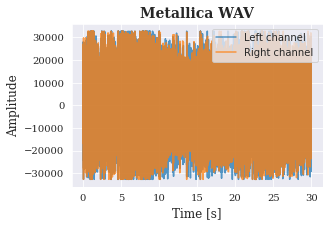

480000


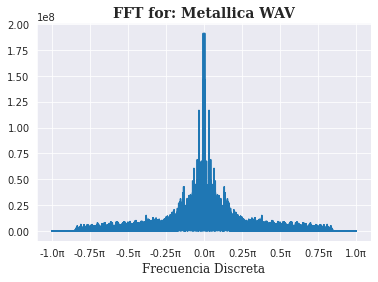

In [208]:
Metallica = np.array(Metallica_Data[:, Canal])

length = Metallica_Data.shape[0] / samplerate_Metallica
print(f"length Metallica= {length}s")

print('Sample rate Metallica: {}'.format(Metallica_sf.samplerate))
print('Channels: {}'.format(Metallica_sf.channels))
print('Subtype: {}'.format(Metallica_sf.subtype))
time = np.linspace(0., length, Metallica_Data.shape[0])
sns.set_style('darkgrid')
fig = plt.figure(figsize=(4.5,3))
plt.plot(time, 2**(Nbits_Metallica-1)*Metallica_Data[:, 0], label="Left channel", alpha = 0.75)
plt.plot(time, 2**(Nbits_Metallica-1)*Metallica_Data[:, 1], label="Right channel", alpha = 0.75)
plt.legend(loc='upper right')
plt.xlabel("Time [s]", fontdict = {'fontsize': 12, 'fontname': 'serif'})
plt.ylabel("Amplitude", fontdict = {'fontsize': 12, 'fontname': 'serif'})
plt.title("Metallica WAV", fontdict = {'fontsize': 14, 'fontweight': 'bold', 'fontname': 'serif'})
plt.xticks(fontsize = 10, fontname = 'serif')
plt.yticks(fontsize = 10, fontname = 'serif')
plt.show()
Metallica = 2**(Nbits_Metallica-1)*Metallica
FoureirPlots(Metallica, samplerate_Metallica, 'Metallica')

number of channels Mozart= 2
length Mozart= 68.90625s
Sample rate Mozart: 16000
Channels: 2
Subtype: PCM_16


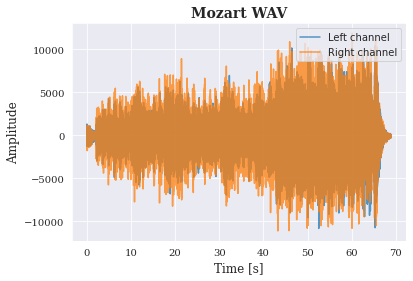

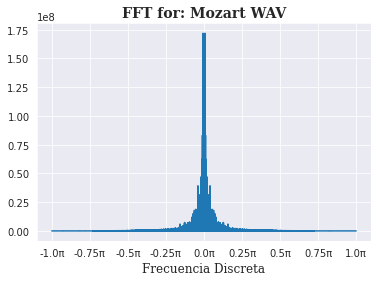

In [161]:
print(f"number of channels Mozart= {Mozart_Data.shape[1]}")
Mozart = np.array(Mozart_Data[:, Canal])
length = Mozart_Data.shape[0] / samplerate_Mozart
print(f"length Mozart= {length}s")

print('Sample rate Mozart: {}'.format(Mozart_sf.samplerate))
print('Channels: {}'.format(Mozart_sf.channels))
print('Subtype: {}'.format(Mozart_sf.subtype))

time = np.linspace(0., length, Mozart_Data.shape[0])
plt.plot(time, 2**(Nbits_Mozart-1)*Mozart_Data[:, 0], label="Left channel", alpha = 0.75)
plt.plot(time, 2**(Nbits_Mozart-1)*Mozart_Data[:, 1], label="Right channel", alpha = 0.75)
plt.legend(loc='upper right')
plt.xlabel("Time [s]", fontdict = {'fontsize': 12, 'fontname': 'serif'})
plt.ylabel("Amplitude", fontdict = {'fontsize': 12, 'fontname': 'serif'})
plt.title("Mozart WAV", fontdict = {'fontsize': 14, 'fontweight': 'bold', 'fontname': 'serif'})
plt.xticks(fontsize = 10, fontname = 'serif')
plt.yticks(fontsize = 10, fontname = 'serif')
plt.show()
Mozart = 2**(Nbits_Mozart-1)*Mozart
FoureirPlots(Mozart, samplerate_Mozart, 'Mozart')

number of channels Nirvana= 2
length Nirvana= 20.0s
Sample rate Mozart: 16000
Channels: 2
Subtype: PCM_16


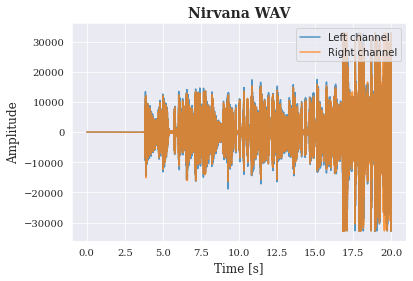

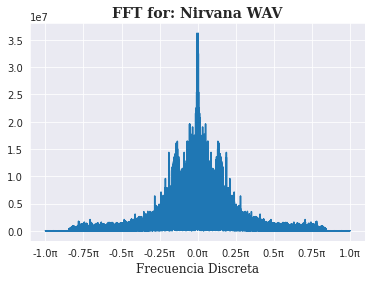

In [162]:
print(f"number of channels Nirvana= {Nirvana_Data.shape[1]}")
Nirvana = np.array(Nirvana_Data[:, Canal])
length = Nirvana_Data.shape[0] / samplerate_Nirvana
print(f"length Nirvana= {length}s")

print('Sample rate Mozart: {}'.format(Nirvana_sf.samplerate))
print('Channels: {}'.format(Nirvana_sf.channels))
print('Subtype: {}'.format(Nirvana_sf.subtype))

time = np.linspace(0., length, Nirvana_Data.shape[0])
plt.plot(time, 2**(Nbits_Nirvana-1)*Nirvana_Data[:, 0], label="Left channel", alpha = 0.75)
plt.plot(time, 2**(Nbits_Nirvana-1)*Nirvana_Data[:, 1], label="Right channel", alpha = 0.75)
plt.legend(loc='upper right')
plt.xlabel("Time [s]", fontdict = {'fontsize': 12, 'fontname': 'serif'})
plt.ylabel("Amplitude", fontdict = {'fontsize': 12, 'fontname': 'serif'})
plt.title("Nirvana WAV", fontdict = {'fontsize': 14, 'fontweight': 'bold', 'fontname': 'serif'})
plt.xticks(fontsize = 10, fontname = 'serif')
plt.yticks(fontsize = 10, fontname = 'serif')
plt.show()
Nirvana = 2**(Nbits_Nirvana-1)*Nirvana
FoureirPlots(Nirvana, samplerate_Nirvana, 'Nirvana')

# Codificador (X[n] a Y[n])
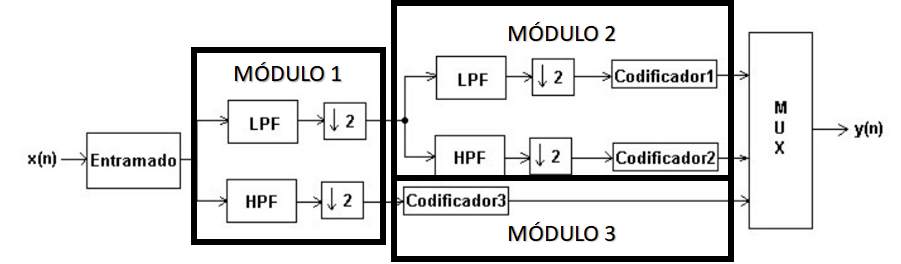

## Módulo 1: Aplicación Filtros LP/HP y Diezmador

### Filtros LP Cod Mod 1



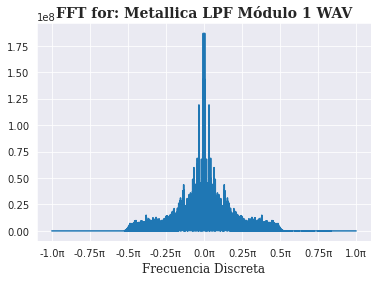

In [163]:
[Metallica_w_LP_Mod1, Metallica_Filt_LP_Mod1, Metallica_SP_LP_Mod1] = Filtro_LP(Metallica)
FoureirPlots(Metallica_Filt_LP_Mod1, samplerate_Metallica, 'Metallica LPF Módulo 1')

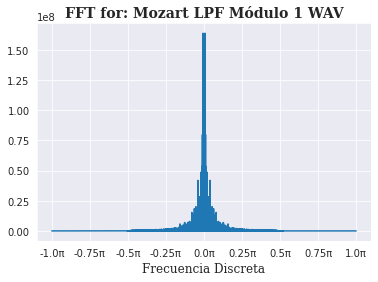

In [164]:
[Mozart_w_LP_Mod1, Mozart_Filt_LP_Mod1, Mozart_SP_LP_Mod1] = Filtro_LP(Mozart)
FoureirPlots(Mozart_Filt_LP_Mod1, samplerate_Mozart, 'Mozart LPF Módulo 1')

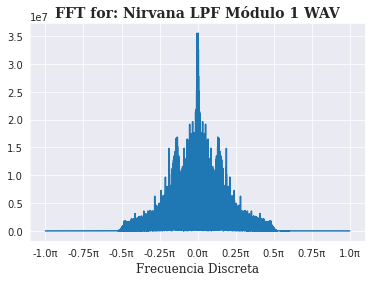

In [165]:
[Nirvana_w_LP_Mod1, Nirvana_Filt_LP_Mod1, Nirvana_SP_LP_Mod1] = Filtro_LP(Nirvana)
FoureirPlots(Nirvana_Filt_LP_Mod1, samplerate_Nirvana, 'Nirvana LPF Módulo 1')

### Filtros HP Cod Mod 1



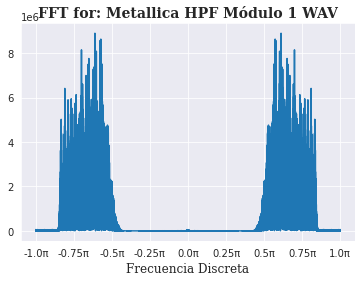

In [166]:
[Metallica_w_HP_Mod1, Metallica_Filt_HP_Mod1, Metallica_SP_HP_Mod1] = Filtro_HP(Metallica)
FoureirPlots(Metallica_Filt_HP_Mod1, samplerate_Metallica, 'Metallica HPF Módulo 1')

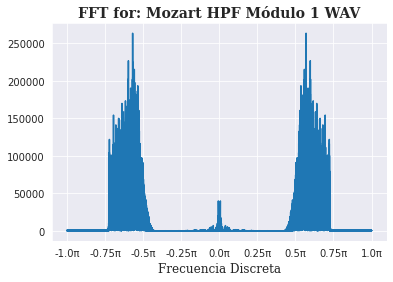

In [167]:
[Mozart_w_HP_Mod1, Mozart_Filt_HP_Mod1, Mozart_SP_HP_Mod1] = Filtro_HP(Mozart)
FoureirPlots(Mozart_Filt_HP_Mod1, samplerate_Mozart, 'Mozart HPF Módulo 1')

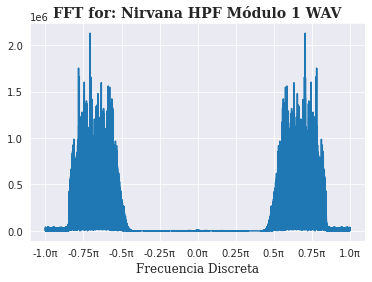

In [168]:
[Nirvana_w_HP_Mod1, Nirvana_Filt_HP_Mod1, Nirvana_SP_HP_Mod1] = Filtro_HP(Nirvana)
FoureirPlots(Nirvana_Filt_HP_Mod1, samplerate_Nirvana, 'Nirvana HPF Módulo 1')

### Aplicar Diezmado a las Señales

In [169]:
# Filtradas LP
Metallica_LP_Mod1 = diezmador(Metallica_Filt_LP_Mod1,2)
Mozart_LP_Mod1 = diezmador(Mozart_Filt_LP_Mod1,2)
Nirvana_LP_Mod1 = diezmador(Nirvana_Filt_LP_Mod1,2)

# Filtradas HP
Metallica_HP_Mod1 = diezmador(Metallica_Filt_HP_Mod1,2)
Mozart_HP_Mod1 = diezmador(Mozart_Filt_HP_Mod1,2)
Nirvana_HP_Mod1 = diezmador(Nirvana_Filt_HP_Mod1,2)

## Módulo 2: Aplicación Filtros LP/HP, Diezmador y Cuantizador 1 - 2

### Filtros LP Cod Mod 2



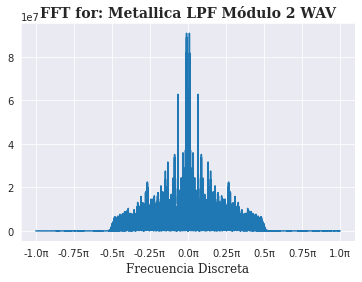

In [170]:
[Metallica_w_LP_Mod2, Metallica_Filt_LP_Mod2, Metallica_SP_LP_Mod2] = Filtro_LP(Metallica_LP_Mod1)
FoureirPlots(Metallica_Filt_LP_Mod2, samplerate_Metallica, 'Metallica LPF Módulo 2')

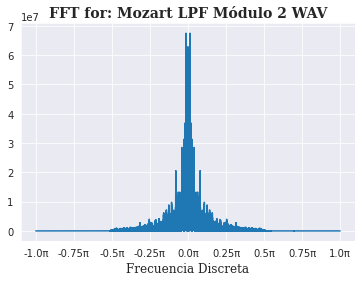

In [171]:
[Mozart_w_LP_Mod2, Mozart_Filt_LP_Mod2, Mozart_SP_LP_Mod2] = Filtro_LP(Mozart_LP_Mod1)
FoureirPlots(Mozart_Filt_LP_Mod2, samplerate_Mozart, 'Mozart LPF Módulo 2')

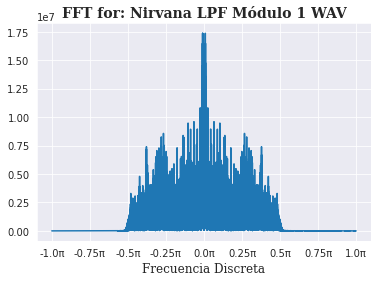

In [172]:
[Nirvana_w_LP_Mod2, Nirvana_Filt_LP_Mod2, Nirvana_SP_LP_Mod2] = Filtro_LP(Nirvana_LP_Mod1)
FoureirPlots(Nirvana_Filt_LP_Mod2, samplerate_Nirvana, 'Nirvana LPF Módulo 1')

### Filtros HP Cod Mod 2



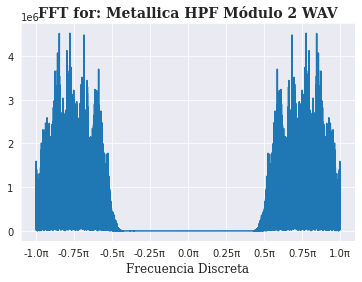

In [173]:
[Metallica_w_HP_Mod2, Metallica_Filt_HP_Mod2, Metallica_SP_HP_Mod2] = Filtro_HP(Metallica_HP_Mod1)
FoureirPlots(Metallica_Filt_HP_Mod2, samplerate_Metallica, 'Metallica HPF Módulo 2')

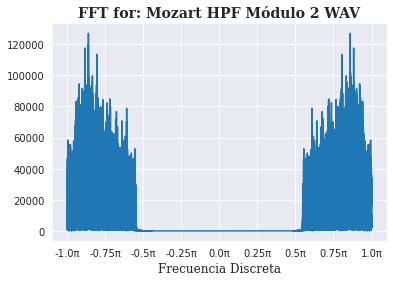

In [174]:
[Mozart_w_HP_Mod2, Mozart_Filt_HP_Mod2, Mozart_SP_HP_Mod2] = Filtro_HP(Mozart_HP_Mod1)
FoureirPlots(Mozart_Filt_HP_Mod2, samplerate_Mozart, 'Mozart HPF Módulo 2')

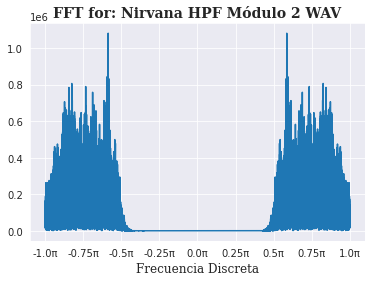

In [175]:
[Nirvana_w_HP_Mod2, Nirvana_Filt_HP_Mod2, Nirvana_SP_HP_Mod2] = Filtro_HP(Nirvana_HP_Mod1)
FoureirPlots(Nirvana_Filt_HP_Mod2, samplerate_Nirvana, 'Nirvana HPF Módulo 2')

### Aplicar Diezmado a las Señales

In [176]:
# Filtradas LP
Metallica_LP_Mod2 = diezmador(Metallica_Filt_LP_Mod2,2)
Mozart_LP_Mod2 = diezmador(Mozart_Filt_LP_Mod2,2)
Nirvana_LP_Mod2 = diezmador(Nirvana_Filt_LP_Mod2,2)

# Filtradas HP
Metallica_HP_Mod2 = diezmador(Metallica_Filt_HP_Mod2,2)
Mozart_HP_Mod2 = diezmador(Mozart_Filt_HP_Mod2,2)
Nirvana_HP_Mod2 = diezmador(Nirvana_Filt_HP_Mod2,2)

### Cuantizador 1 - Codificador 1

In [177]:
Nbits_C1 = 6
Metallica_Cuant_1 = cuantizador(Metallica_LP_Mod2, Nbits_C1)
Nirvana_Cuant_1 = cuantizador(Nirvana_LP_Mod2, Nbits_C1)
Mozart_Cuant_1 = cuantizador(Mozart_LP_Mod2, Nbits_C1)

### Cuantizador 2 . COdificador 2

In [178]:
Nbits_C2 = 4
Metallica_Cuant_2 = cuantizador(Metallica_HP_Mod2, Nbits_C2)
Nirvana_Cuant_2 = cuantizador(Nirvana_HP_Mod2, Nbits_C2)
Mozart_Cuant_2 = cuantizador(Mozart_HP_Mod2, Nbits_C2)

## Módulo 3: Aplicación Cuantizador 3 - Codificador 3

In [179]:
Nbits_C3 = 4
Metallica_Cuant_3 = cuantizador(Metallica_HP_Mod1, Nbits_C3)
Nirvana_Cuant_3 = cuantizador(Nirvana_HP_Mod1, Nbits_C3)
Mozart_Cuant_3 = cuantizador(Mozart_HP_Mod1, Nbits_C3)

# Decodificador  (Y[n] a X[n])
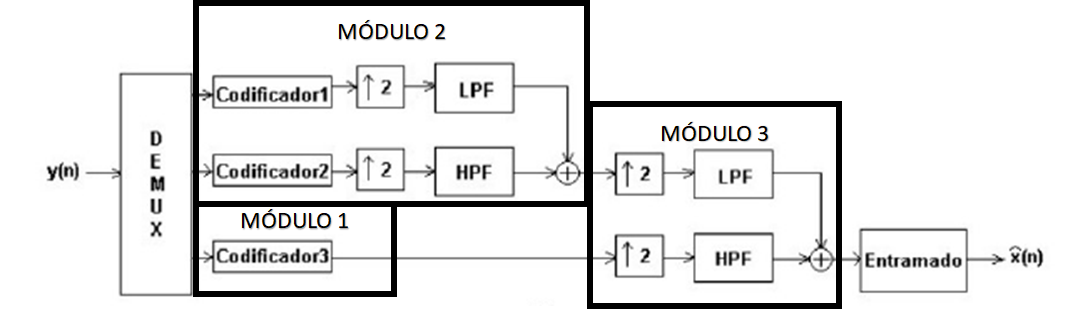

## Módulo 1 Deco: Aplicación Decuantizador 3

In [180]:
Metallica_DeCuant_3 = Decuantizador(Metallica_HP_Mod1, Nbits_C3)
Nirvana_DeCuant_3 = Decuantizador(Nirvana_HP_Mod1, Nbits_C3)
Mozart_DeCuant_3 = Decuantizador(Mozart_HP_Mod1, Nbits_C3)

## Módulo 2 Deco: Aplicación Decuantizador 1 y 2, Interporlado y Filtro LPF y HPF

### Decuantizador 1

In [188]:
Metallica_DeCuant_1 = Decuantizador(Metallica_Cuant_1, Nbits_C1)
Nirvana_DeCuant_1 = Decuantizador(Nirvana_Cuant_1, Nbits_C1)
Mozart_DeCuant_1 = Decuantizador(Mozart_Cuant_1, Nbits_C1)

### Decuantizador 2

In [189]:
Metallica_DeCuant_2 = Decuantizador(Metallica_Cuant_2, Nbits_C2)
Nirvana_DeCuant_2 = Decuantizador(Nirvana_Cuant_2, Nbits_C2)
Mozart_DeCuant_2 = Decuantizador(Mozart_Cuant_2, Nbits_C2)

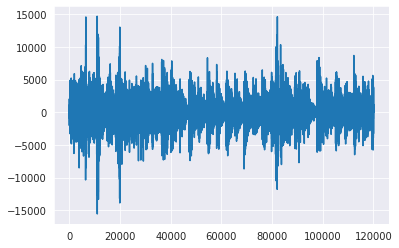

In [192]:
plt.plot(Metallica_DeCuant_2)

### Aplicar Interpolación a las Señales 

In [190]:
# Para Ser filtradas LP
Metallica_FLP_Mod2 = interpolador(Metallica_DeCuant_1,2)
Mozart_FLP_Mod2 = interpolador(Mozart_DeCuant_1,2)
Nirvana_FLP_Mod2 = interpolador(Nirvana_DeCuant_1,2)

# Para Ser filtradas HP
Metallica_FHP_Mod2 = interpolador(Metallica_DeCuant_2,2)
Mozart_FHP_Mod2 = interpolador(Mozart_DeCuant_2,2)
Nirvana_FHP_Mod2 = interpolador(Nirvana_DeCuant_2,2)

### Filtros LP Deco Mod 2



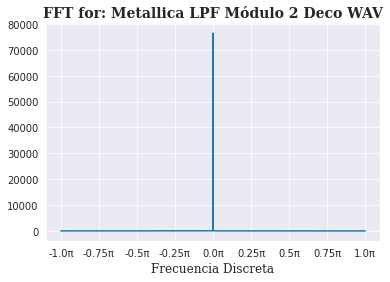

In [198]:
[Metallica_w_LP_DecoMod2, Metallica_Filt_LP_DecoMod2, Metallica_SP_LP_DecoMod2] = Filtro_LP(Metallica_FLP_Mod2)
FoureirPlots(Metallica_w_LP_DecoMod2, samplerate_Metallica, 'Metallica LPF Módulo 2 Deco')

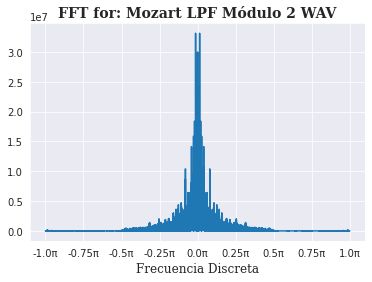

In [196]:
[Mozart_w_LP_DecoMod2, Mozart_Filt_LP_DecoMod2, Mozart_SP_LP_DecoMod2] = Filtro_LP(Mozart_FLP_Mod2)
FoureirPlots(Mozart_Filt_LP_DecoMod2, samplerate_Mozart, 'Mozart LPF Módulo 2')

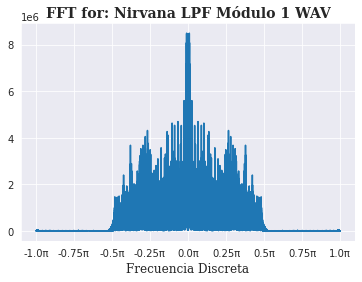

In [197]:
[Nirvana_w_LP_DecoMod2, Nirvana_Filt_LP_DecoMod2, Nirvana_SP_LP_DecoMod2] = Filtro_LP(Nirvana_FLP_Mod2)
FoureirPlots(Nirvana_Filt_LP_DecoMod2, samplerate_Nirvana, 'Nirvana LPF Módulo 1')

### Filtros HP Deco Mod 2



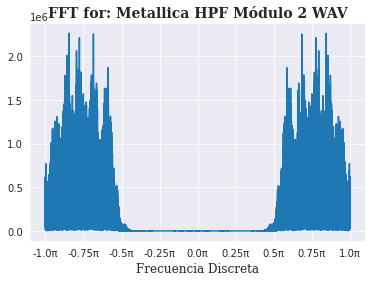

In [203]:
[Metallica_w_HP_DecoMod2, Metallica_Filt_HP_DecoMod2, Metallica_SP_HP_DecoMod2] = Filtro_HP(Metallica_FHP_Mod2)
FoureirPlots(Metallica_Filt_HP_DecoMod2, samplerate_Metallica, 'Metallica HPF Módulo 2')

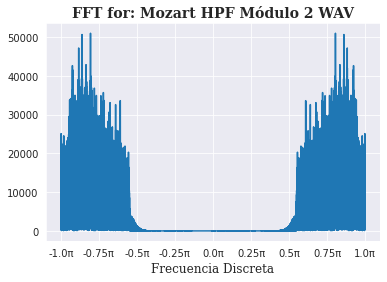

In [204]:
[Mozart_w_HP_DecoMod2, Mozart_Filt_HP_DecoMod2, Mozart_SP_HP_DecoMod2] = Filtro_HP(Mozart_FHP_Mod2)
FoureirPlots(Mozart_Filt_HP_DecoMod2, samplerate_Mozart, 'Mozart HPF Módulo 2')

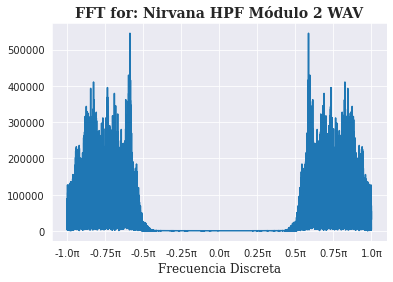

In [205]:
[Nirvana_w_HP_DecoMod2, Nirvana_Filt_HP_DecoMod2, Nirvana_SP_HP_DecoMod2] = Filtro_HP(Nirvana_FHP_Mod2)
FoureirPlots(Nirvana_Filt_HP_DecoMod2, samplerate_Nirvana, 'Nirvana HPF Módulo 2')

### Señal Salida Módulo 2

In [207]:
Metallica_Deco_Mod2 = Metallica_w_HP_DecoMod2 + Metallica_w_LP_DecoMod2
Mozart_Deco_Mod2 = Mozart_w_HP_DecoMod2 + Mozart_w_LP_DecoMod2
Nirvana_Deco_Mod2 = Nirvana_w_HP_DecoMod2 + Nirvana_w_LP_DecoMod2


160000

## Módulo 3 Deco: Interpolador, Filtro LPF y HPF

### Aplicar Interpolación a las Señales 

In [209]:
# Para Ser filtradas LP
Metallica_FLP_Mod3 = interpolador(Metallica_Deco_Mod2,2)
Mozart_FLP_Mod3 = interpolador(Mozart_Deco_Mod2,2)
Nirvana_FLP_Mod3 = interpolador(Nirvana_Deco_Mod2,2)

# Para Ser filtradas HP
Metallica_FHP_Mod3 = interpolador(Metallica_DeCuant_3,2)
Mozart_FHP_Mod3 = interpolador(Mozart_DeCuant_3,2)
Nirvana_FHP_Mod3 = interpolador(Nirvana_DeCuant_3,2)

### Filtros LP Deco Mod 2



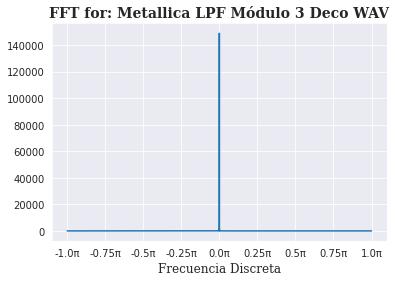

In [213]:
[Metallica_w_LP_DecoMod3, Metallica_Filt_LP_DecoMod3, Metallica_SP_LP_DecoMod3] = Filtro_LP(Metallica_FLP_Mod3)
FoureirPlots(Metallica_Filt_LP_DecoMod3, samplerate_Metallica, 'Metallica LPF Módulo 3 Deco')

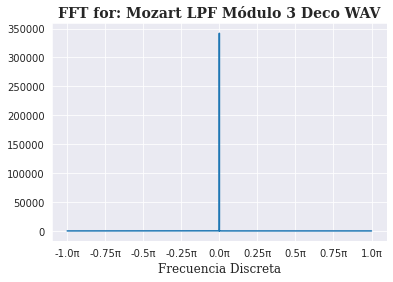

In [214]:
[Mozart_w_LP_DecoMod3, Mozart_Filt_LP_DecoMod3, Mozart_SP_LP_DecoMod3] = Filtro_LP(Mozart_FLP_Mod3)
FoureirPlots(Mozart_Filt_LP_DecoMod3, samplerate_Mozart, 'Mozart LPF Módulo 3 Deco')

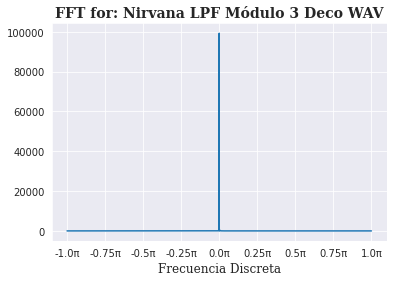

In [215]:
[Nirvana_w_LP_DecoMod3, Nirvana_Filt_LP_DecoMod3, Nirvana_SP_LP_DecoMod3] = Filtro_LP(Nirvana_FLP_Mod3)
FoureirPlots(Nirvana_Filt_LP_DecoMod3, samplerate_Nirvana, 'Nirvana LPF Módulo 3 Deco')

### Filtros HP Deco Mod 2



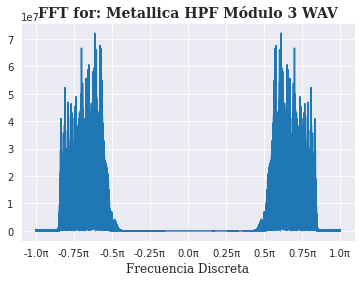

In [216]:
[Metallica_w_HP_DecoMod3, Metallica_Filt_HP_DecoMod3, Metallica_SP_HP_DecoMod3] = Filtro_HP(Metallica_FHP_Mod3)
FoureirPlots(Metallica_Filt_HP_DecoMod3, samplerate_Metallica, 'Metallica HPF Módulo 3')

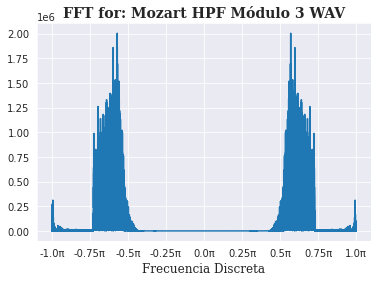

In [217]:
[Mozart_w_HP_DecoMod3, Mozart_Filt_HP_DecoMod3, Mozart_SP_HP_DecoMod3] = Filtro_HP(Mozart_FHP_Mod3)
FoureirPlots(Mozart_Filt_HP_DecoMod3, samplerate_Mozart, 'Mozart HPF Módulo 3')

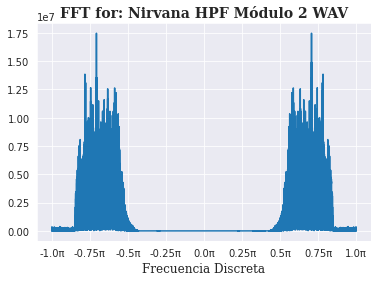

In [218]:
[Nirvana_w_HP_DecoMod3, Nirvana_Filt_HP_DecoMod3, Nirvana_SP_HP_DecoMod3] = Filtro_HP(Nirvana_FHP_Mod3)
FoureirPlots(Nirvana_Filt_HP_DecoMod3, samplerate_Nirvana, 'Nirvana HPF Módulo 2')

### Señal Salida Módulo 3

In [219]:
Metallica_Deco_Mod3 = Metallica_Filt_HP_DecoMod3 + Metallica_Filt_LP_DecoMod3
Mozart_Deco_Mod3 = Mozart_Filt_HP_DecoMod3 + Mozart_Filt_LP_DecoMod3
Nirvana_Deco_Mod3 = Nirvana_Filt_HP_DecoMod3 + Nirvana_Filt_LP_DecoMod3


ValueError: ignored

# Comparación Entrada vs Salida